# Starter Kit: Second International StepUP Competition (IJCB 2026)

This notebook provides example code for: 
1. Training a deep CNN for feature extraction, using the Training Set (StepUP-P150 Database)
2. Loading the Reference Set and applying the CNN for feature extraction
3. Loading the Probe Set, applying the CNN for feature extraction, and using a distance-based metric to perform identity verification
4. Exporting the verification results in the format needed for submission to the CodaBench platform 

In [1]:
import numpy as np
import pathlib
import pandas as pd
import itertools
import zipfile
import os
import math

from torchvision import transforms
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.utils import _triple
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from pytorch_metric_learning import losses
from scipy.spatial.distance import  cdist 

import umap
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d

## Specify Dataset Filepaths
Before running this notebook, download the three datasets and update the filepath below. 

In [2]:
# TODO: Update this filepath for your environment.
dataset_root = pathlib.Path('/home/shared/competition/')

datapath_train = dataset_root / '1 - Training'
datapath_ref = dataset_root / '2 - Reference' 
datapath_probe = dataset_root / '3 - Probe'

# Confirm that the dataset folders exist before contining.
# If this results in an error, double check that you have downloaded and extracted the dataset successfully and correctly updated the filepath above.
for filepath in [datapath_train, datapath_ref, datapath_probe]:
  assert(filepath.exists())


## Step 1: Training

### Load Training Metadata

Load the StepUP-P150 metadata. This loads metadata for entire dataset by default, but can be filtered as desired - modify `participant_IDs`, `speed_IDs` and `footwear_IDs` to load fewer individuals or conditions. Refer to the following descriptions of the conditions:


| Speed ID | Description | | Footwear ID | Description |
| --- | --- | --- | --- | --- |
| W1 | Preferred Speed | | BF | Without Footwear (Barefoot or Sockfoot) |
| W2 | Slow-to-Stop | | ST | Standard Shoes (Adidas Grand Court 2.0 Sneakers) |
| W3 | Slower than Preferred | | P1 | Participant's First Pair of Personal Footwear | 
| W4 | Faster than Preferred | | P2 | Participant's Second Pair of Personal Footwear | 

In [3]:
participant_IDs = np.arange(1,151) 
speed_IDs = ['W1','W2','W3','W4']
footwear_IDs = ['BF','ST','P1','P2']

metadata_lst = []
for participant_ID, footwear_ID, speed_ID in itertools.product(participant_IDs, footwear_IDs, speed_IDs):
  metadata_path = datapath_train / f'{participant_ID:03}' / footwear_ID / speed_ID / 'metadata.csv'
  metadata_lst.append(pd.read_csv(metadata_path))

metadata_train = pd.concat(metadata_lst).reset_index(drop=True)

# optional: remove any samples flagged to 'Exclude' - these include incomplete or outlier footsteps 
metadata_train = metadata_train.query('Exclude == False')

metadata_train.head()

,ParticipantID,Footwear,Speed,FootstepID,PassID,StartFrame,EndFrame,Ymin,Ymax,Xmin,...,Side,Standing,Incomplete,Rscore,Outlier,Exclude,RotationAngle,FootLength,FootWidth,MeanGRF
0,1,BF,W1,0,0,212,288,76,131,167,...,Right,0,0,0.248545,0,0,4.246666,53.0,19.0,23270.396040
1,1,BF,W1,1,0,276,348,233,291,191,...,Left,0,0,1.126682,0,0,1.618202,55.0,20.0,25024.029703
2,1,BF,W1,2,0,331,407,385,439,167,...,Right,0,0,0.511779,0,0,4.133031,53.0,19.0,19953.871287
3,1,BF,W1,3,0,393,469,537,593,189,...,Left,0,0,0.188634,0,0,3.611146,55.0,18.0,20826.940594
5,1,BF,W1,5,1,592,670,608,661,49,...,Right,0,0,0.345517,0,0,-10.230420,53.0,20.0,21352.158416


### Define Function for Pairing Training Samples into Strides

The probe and reference sets are constructed from consecutive left–right footstep pairs (i.e., full strides), allowing information from both sides of the body to be used for verification. Therefore, we also group the training footsteps into consecutive left–right pairs using the metadata. We'll use overlapping pairs for training, and non-overlapping pairs for validation.  


In [4]:
def get_pairs(metadata,overlapping = True):
    ''' Function for grouping consecutive footsteps into left/right pairs.
    Returns new dataframe with the indices of the paired samples.'''

    pair_idx = []

    for _,pass_metadata in metadata.groupby(['ParticipantID','PassID','Footwear','Speed']):
        pass_idx = pass_metadata.index.to_numpy()
        
        pairs = np.stack((pass_idx[:-1],pass_idx[1:])).T

        for i,j in pairs:

            side_i = pass_metadata['Side'].loc[i]
            side_j = pass_metadata['Side'].loc[j]

            is_diff = side_i != side_j 
            is_consec = np.abs(pass_metadata['FootstepID'][i] - pass_metadata['FootstepID'][j]) == 1

            if is_diff and is_consec:
                # append pair (left followed by right)
                if side_i == 'Left':
                    pair_idx.append([i,j])
                else:
                    pair_idx.append([j,i])
    
    pair_idx = np.array(pair_idx)
    
    if not overlapping: # remove overlapping strides 
        pair_idx = remove_overlap(pair_idx)
        
    left_ids = metadata_train['FootstepID'].loc[pair_idx[:,0]]
    right_ids = metadata_train['FootstepID'].loc[pair_idx[:,1]]

    # create new dataframe
    pair_metadata = metadata_train[['ParticipantID','Footwear','Speed','Side','FootstepID']].loc[pair_idx[:,0]]
    
    pair_metadata['FootstepID'] = list(np.stack((left_ids,right_ids),axis = 1))
    pair_metadata['Side'] = list(np.tile(['Left','Right'],(pair_idx.shape[0],1)))
    pair_metadata.sort_index(inplace=True)
    pair_metadata.reset_index(drop=True,inplace=True)

    return pair_metadata

def remove_overlap(pair_idx):

    '''Greedy algorithm to remove strides that have shared left or right samples with other strides, so
    that all of the left/right pairs consist of two unique footsteps. Keeps the first instance of each footstep.
    '''
    used = set()
    keep_idx = []
    
    for i,idx in enumerate(pair_idx):
        l = idx[0]
        r = idx[1]

        # check set membership
        if l not in used and r not in used:
            keep_idx.append(i)
            used.update({l, r})
            
    return pair_idx[keep_idx]

### Define a Dataset Class for the Training Set

This class loads the training samples as they are needed during batch creation. Each batch consists of three tensors: 1) left footstep samples, 2) corresonding right footstep samples, and 3) the class labels. Each footstep has a size of 101 $\times$ 75 $\times$ 40 (time frames, height, width). All footsteps have been normalized in time and roughly aligned - see the [dataset paper](https://doi.org/10.1038/s41597-025-05792-1) for more information about preprocessing.

**Note**: this class automatically flips right footsteps along their x-axis so that all samples appear like 'left' footsteps. This is to improve sample uniformity during model training. 

In [11]:
class Training_Dataset(Dataset):
    '''torch dataset class for loading footstep samples during batch creation.
    Pass in the original metadata dataframe to load individual footsteps (i.e., batched samples will consist
    of n_batch mixed left and right footsteps). Pass in the paired version of the metadata to create two tensors in each
    batch, one for left footsteps and another for their corresponding right footsteps. This is returned 
    as a tuple (x_left, x_right) with n_batch samples in each tensor. 
    '''
    def __init__(self, datapath, metadata, transform = None, augmentation = None):

        self.datapath = datapath
        self.transform = transform
        self.augmentation = augmentation

        self.participant_IDs = metadata['ParticipantID'].to_numpy() 
        self.footwear_IDs = metadata['Footwear'].to_numpy()
        self.speed_IDs = metadata['Speed'].to_numpy()
        self.side = metadata['Side'].to_numpy()
        self.footstep_IDs = metadata['FootstepID'].to_numpy()

        # transform labels into integers starting from 0
        le = LabelEncoder()
        self.labels = le.fit_transform(self.participant_IDs)
        self.n_classes = np.unique(self.labels).shape[0]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        participant_ID = self.participant_IDs[idx]
        footwear_ID = self.footwear_IDs[idx]
        speed_ID = self.speed_IDs[idx]
        footstep_ID = self.footstep_IDs[idx].astype(np.int64)
        side = self.side[idx]

        # load dictionary of all footsteps in trial
        sample_path = self.datapath / f'{participant_ID:03}' / footwear_ID / speed_ID / 'pipeline_1.npz' 
        footsteps = np.load(sample_path)

        x = []
        for sd, ID in zip([side],[footstep_ID]) if isinstance(footstep_ID,np.int64) else zip(side,footstep_ID): 

            # get footstep from trial
            footstep = footsteps[f'{ID}'] 

            # flip right footsteps along x axis
            if sd == 'Right':
                footstep = np.flip(footstep,axis = 2)
        
            # add dimension for channel: shape (1,101,75,40) (channel,time,y,x)
            footstep = footstep[None,:,:,:]

            # convert to torch
            footstep = torch.from_numpy(footstep.astype(np.float32))

            # apply transformations/normalization
            if self.transform:
                footstep = self.transform(footstep)

            # apply augmentations if any
            if self.augmentation:
                footstep = self.augmentation(footstep)

            x.append(footstep)

        x = x[0] if len(x) == 1 else tuple(x) 
        y = torch.tensor(self.labels[idx])

        return x, y

### Define Feature Extraction Network

The architecture used for feature extraction is an spatiotemporal convolutional network implemented in PyTorch, based on factored spatial and temporal convolution operations. The FusionNet class is used to fuse the CNN features from the paired left and right footsteps using a fully connected layer. The SpatioTeporalConv class is modified from https://github.com/irhum/R2Plus1D-PyTorch.

In [6]:
class SpatioTemporalConv(nn.Module):
    '''Applies a factored 3D convolution: a 2D convolution over the 
    spatial axes to an intermediate subspace, followed by a 1D convolution over the time 
    axis to produce the final output.'''
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(SpatioTemporalConv, self).__init__()

        kernel_size = _triple(kernel_size)
        stride = _triple(stride)
        padding = _triple(padding)

        spatial_kernel_size =  [1, kernel_size[1], kernel_size[2]]
        spatial_stride =  [1, stride[1], stride[2]]
        spatial_padding =  [0, padding[1], padding[2]]

        temporal_kernel_size = [kernel_size[0], 1, 1]
        temporal_stride =  [stride[0], 1, 1]
        temporal_padding =  [padding[0], 0, 0]

        intermed_channels = int(math.floor((kernel_size[0] * kernel_size[1] * kernel_size[2] * in_channels * out_channels)/ \
                            (kernel_size[1]* kernel_size[2] * in_channels + kernel_size[0] * out_channels)))


        self.spatial_conv = nn.Conv3d(in_channels, intermed_channels, spatial_kernel_size,
                                    stride=spatial_stride, padding=spatial_padding, bias=bias)
        self.norm = nn.InstanceNorm3d(intermed_channels)
        self.relu = nn.ReLU()

        self.temporal_conv = nn.Conv3d(intermed_channels, out_channels, temporal_kernel_size, 
                                    stride=temporal_stride, padding=temporal_padding, bias=bias)

    def forward(self, x):
        x = self.relu(self.norm(self.spatial_conv(x)))
        x = self.temporal_conv(x)
        return x
 
class CNN3D(nn.Module):
    '''A convolutional network consisting of three spatiotemporal convolution layers, followed by 
    a max pooling layer. Accepts an input of size (batch size, channels, time, width, height).'''

    def __init__(self, n_channels = 1):
        super(CNN3D, self).__init__()

        self.conv1 = SpatioTemporalConv(n_channels, 16, [5, 5, 5], stride=[2, 2, 2]) 
        self.conv2 = SpatioTemporalConv(16, 32, [3, 3, 3], stride=[1, 1, 1]) 
        self.conv3 = SpatioTemporalConv(32, 64, [3, 3, 3], stride=[1, 1, 1]) 

        self.norm1 = nn.InstanceNorm3d(16)
        self.norm2 = nn.InstanceNorm3d(32)
        self.norm3 = nn.InstanceNorm3d(64)
        self.relu = nn.ReLU()

        # global max pooling of the output
        self.pool = nn.AdaptiveMaxPool3d((2,2,2))

    def forward(self, x):
        x = self.relu(self.norm1(self.conv1(x)))
        x = self.relu(self.norm2(self.conv2(x)))
        x = self.relu(self.norm3(self.conv3(x)))

        x = self.pool(x)
        
        return x.view(-1, 512)

class FusionNet(nn.Module):

    '''Fusion head that concatenates features from the left and right footsteps
     prior to passing them through a fully connected layer. '''
    
    def __init__(self, net, n_classes, in_features = 512, out_features = 512):
        super(FusionNet, self).__init__()

        self.backbone = net
        self.fusionlayer = nn.Linear(in_features*2,out_features)
        self.outputlayer = nn.Linear(out_features,n_classes)
        
    def forward(self, x_left, x_right):
        embeds_left = self.backbone(x_left)
        embeds_right = self.backbone(x_right)

        embeds = torch.concatenate((embeds_left,embeds_right),1)

        embeds = self.fusionlayer(embeds)
        logits = self.outputlayer(embeds)

        return logits, embeds

### Create Datasets, Initialize Network and Set Training Hyperparameters

Define preprocessing functions for the footsteps. These normalize the amplitude of each footstep between 0 and 1 and downsample them spatially and temporally to 64 frames $\times$ 64 pixels $\times$ 32 pixels.

In [7]:
# min-max scaling to normalize between zero and 1
def normalize(x): 
    x = (x - x.min())/(x.max() - x.min())
    if torch.isnan(x).any():
        x[torch.isnan(x)] = 0
    return x

# use linear interpolation to downsample 3D footstep
def resize(x,size = (64,64,32)): 
    x = F.interpolate(x.unsqueeze(0) ,size = size,mode = 'trilinear')
    return x.squeeze(0)

Define functions for estimating verification performance, which we will use for monitoring validation set performance during training. These functions perform comparisons between all possible combinations of samples using a cosine similarity metric, and then compute the equal error rate (EER) based on the scores from the matched and non-matched comparisons.    

In [8]:
def verification_comparisons(embeds,labels):

    matched_scores = []
    non_matched_scores = []

    for user in np.unique(labels):

        pos_idx = labels == user
        neg_idx = ~pos_idx 
        
        # compare matched pairs
        dist_matrix = cdist(embeds[pos_idx],embeds[pos_idx],'cosine')

        # ignore self-comparisons
        mask = ~np.eye(*dist_matrix.shape, dtype=bool)
        matched_score = 1 - dist_matrix[mask].flatten()

        # compare non-matched pairs
        dist_matrix = cdist(embeds[pos_idx],embeds[neg_idx],'cosine')
        non_matched_score = 1 - dist_matrix.flatten()

        matched_scores.append(matched_score)
        non_matched_scores.append(non_matched_score)

    matched_scores = np.hstack(matched_scores)
    non_matched_scores = np.hstack(non_matched_scores)

    scores = np.hstack((matched_scores,non_matched_scores))
    ground_truth = np.hstack((np.ones(matched_scores.shape),np.zeros(non_matched_scores.shape)))  
    
    return scores, ground_truth

def compute_EER(ground_truth, scores):
    FMR, TMR, _ = roc_curve(ground_truth, scores, pos_label=1)
    EER = 100*brentq(lambda x : 1. - x - interp1d(FMR, TMR)(x), 0., 1.)
    return EER

We construct dataloaders for the training and validation sets. For this baseline implementation, the final ten participants in the dataset are held out for validation.

Note: This split is used for demonstration purposes only. Competition participants are free to use the StepUP-P150 dataset in any way for developing their feature extraction network, and the use of external data is also permitted.

In [9]:
# set hyperparameters
batch_sz = 128
sample_sz = (64,64,32) # downsample image to size (time,height,width)

# create training pairs
train_users = np.arange(1,141) 
metadata_t = metadata_train.query('ParticipantID in @train_users')
metadata_t_paired = get_pairs(metadata_t, overlapping = True) # create overlapping pairs

# create validation pairs
val_users = np.arange(141,151) 
metadata_v = metadata_train.query('ParticipantID in @val_users')
metadata_v_paired = get_pairs(metadata_v, overlapping = False) # use non-overlapping pairs for validation set to avoid leakage

# create transformation pipeline for training set
transform_fn = transforms.Compose([
    lambda x: resize(x,size = sample_sz),
    normalize,
])

# create datasets and dataloaders for training and validation sets
dataset_t = Training_Dataset(datapath_train, metadata_t_paired,transform = transform_fn)
dataloader_t = DataLoader(dataset_t, batch_size=batch_sz, shuffle=True)

dataset_v = Training_Dataset(datapath_train, metadata_v_paired,transform = transform_fn)
dataloader_v = DataLoader(dataset_v, batch_size=batch_sz, shuffle=False)


Plot a few of the transformed training strides. The 3D samples have been flattened into 2D images for display. Note that the right footsteps have been mirrored.

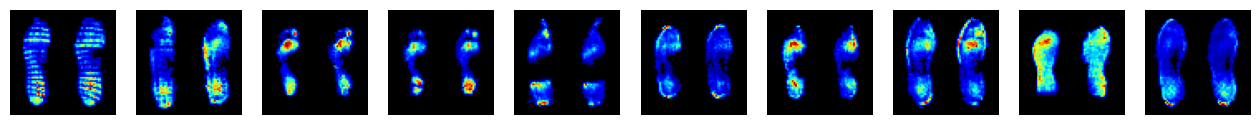

In [10]:
# get one batch of training footsteps
data_iter = iter(dataloader_t)
(footsteps_left,footsteps_right), labels = next(data_iter)  

fig, ax = plt.subplots(1, 10, figsize=(16, 4))

# define colormap
jet = mpl.colormaps['jet'](np.linspace(0, 1, 256))
jet[0] = [0,0,0,1]
cmap = mpl.colors.ListedColormap(jet)

for i in range(10):
    footstep_l = footsteps_left[i].squeeze()
    footstep_r = footsteps_right[i].squeeze()
    img = np.concatenate((footstep_l.max(0)[0],footstep_r.max(0)[0]),axis = 1) # flatten into image for display
    ax[i].imshow(img,cmap = cmap)
    ax[i].set_axis_off()
plt.show()

Initialize network and specify training hyperparameters. Here, we train the model for 10 epochs using a metric loss function from the pytorch-metric-learning library (Circle Loss). 

In [11]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

# set number of training epochs
n_epochs = 10

# create network
backbone = CNN3D()
clf = FusionNet(backbone,dataset_t.n_classes)
clf.to(device)
clf.train()

# use a CircleLoss metric loss function
loss_func = losses.CircleLoss(m = 0.25,gamma = 256)

# create optimizer and learning rate scheduler
optimizer = torch.optim.Adam(clf.parameters(), lr=1e-4) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer, 0.95, last_epoch=-1)

Train the model for n_epochs. Save checkpoints after training.

**Note**: to save time, you can skip this cell and load in the pretrained model in the following cell.

In [ ]:
for epoch in range(n_epochs):
    print('Epoch:',epoch)
    
    ################################ Training Loop ##############################
    clf.train()
    for id_batch, ((x_left_batch,x_right_batch), y_batch) in enumerate(dataloader_t):

        x_left_batch, x_right_batch, y_batch = x_left_batch.to(device), x_right_batch.to(device), y_batch.to(device)

        y_batch_pred,embeds = clf(x_left_batch,x_right_batch)

        embeds = F.normalize(embeds, p=2, dim=1) # L2 normalize embeddings

        loss = loss_func(embeds, y_batch)

        print('Loss:', loss.item())
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

    scheduler.step() # reduce learning rate each epoch

    ################################ Validation Performance ##############################
    clf.eval()
    with torch.no_grad():
        val_embeds = []
        for id_batch, ((x_left_batch,x_right_batch), y_batch) in enumerate(dataloader_v):

            x_left_batch, x_right_batch = x_left_batch.to(device), x_right_batch.to(device)

            y_batch_pred,embeds = clf(x_left_batch,x_right_batch)
            
            embeds = F.normalize(embeds, p=2, dim=1)

            val_embeds.append(embeds.cpu().numpy())
        val_embeds = np.vstack(val_embeds)
            
    scores, ground_truth = verification_comparisons(val_embeds,dataset_v.labels)
    EER = compute_EER(ground_truth,scores)
    print('Validation EER: {:.2f}%'.format(EER))
    

# save checkpoints
state = {
'clf': clf.state_dict(),
'optimizer': optimizer.state_dict(),
'scheduler': scheduler.state_dict(),
'loss_func':loss_func.state_dict(),
'loss': loss,
'epoch': epoch}

torch.save(state, 'model_snapshot.pt')

In [12]:
checkpoint = torch.load('model_snapshot.pt',weights_only = True, map_location = device)
clf.load_state_dict(checkpoint['clf'])

<All keys matched successfully>

Extract the CNN embeddings for the validation samples, compute the estimated verification accuracy for the validation set, and plot a UMAP projection of the embeddings. Each sample is represented by 512 features.  

In [13]:
clf.eval()
val_embeds = []

with torch.no_grad():
    for id_batch, ((x_left_batch,x_right_batch), y_batch) in enumerate(dataloader_v):

        x_left_batch, x_right_batch = x_left_batch.to(device), x_right_batch.to(device)

        y_batch_pred,embeds = clf(x_left_batch,x_right_batch)
        
        embeds = F.normalize(embeds, p=2, dim=1)

        val_embeds.append(embeds.cpu().numpy())

val_embeds = np.vstack(val_embeds)
val_labels = dataset_v.participant_IDs        

print('Number of features per sample:', val_embeds.shape[1])

Number of features per sample: 512


In [14]:
scores, ground_truth = verification_comparisons(val_embeds,val_labels)
EER = compute_EER(ground_truth,scores)
print('Validation EER: {:.2f}%'.format(EER))

Validation EER: 15.34%


/home/robyn/2nd_stepUP_competition/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


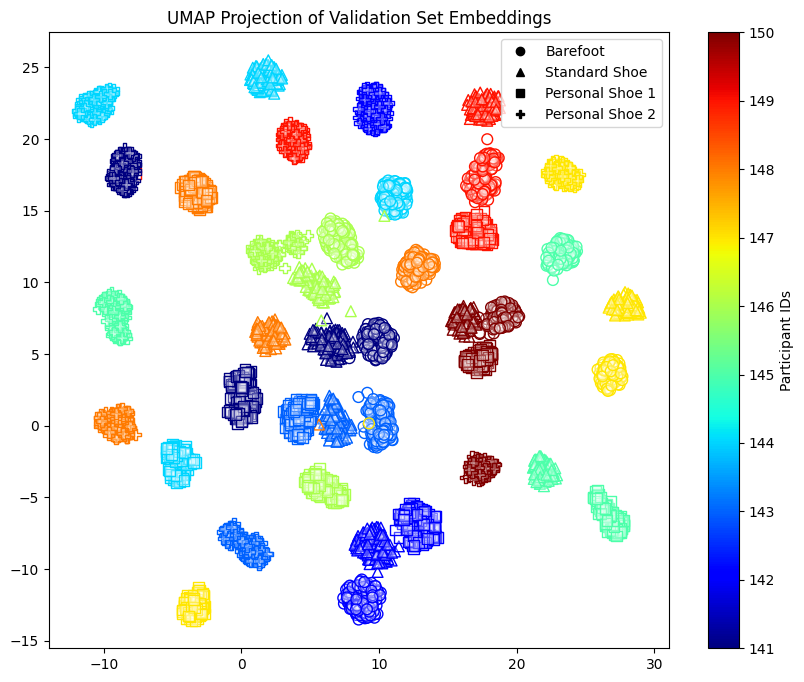

In [15]:
reducer = umap.UMAP(min_dist = 0.9)
umap_proj = reducer.fit_transform(val_embeds)

cmap = mpl.colormaps['jet']
norm = plt.Normalize(vmin = val_labels.min(),vmax = val_labels.max())

fig,ax = plt.subplots(figsize=(10, 8))
m = ['o','^','s','P'] # use different markers for each footwear condition
for iShoe,shoe_type in enumerate(['BF','ST','P1','P2']):
    shoe_idx = dataset_v.footwear_IDs == shoe_type

    scatter = plt.scatter(umap_proj[shoe_idx, 0], umap_proj[shoe_idx, 1], color=cmap(norm(val_labels[shoe_idx])),  marker = m[iShoe],facecolor = [1,1,1,0.3],s = 60)

plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax = ax,ticks = np.unique(val_labels), label = 'Participant IDs')
plt.legend([mpl.lines.Line2D([0],[0],c = 'k',marker = mi,linestyle = 'None') for mi in m],('Barefoot','Standard Shoe','Personal Shoe 1','Personal Shoe 2'))
plt.title("UMAP Projection of Validation Set Embeddings")
plt.show()

## Step 2. Get Embeddings for Reference Samples

### Load Metadata and Data
The reference set consists of 15 users with 5 footstep pairs each (5 left and 5 right). The metadata for the reference set is stored in a single spreadsheet, and the footsteps are stored in a dictionary format (one key per footstep) in a single .npz file. 

In [16]:
metadata_ref = pd.read_csv(datapath_ref / 'reference_metadata.csv',index_col = 'Index') # TODO: rename
footsteps_ref = np.load(datapath_ref / 'reference_data.npz')

metadata_ref.head()

,ParticipantID
Index,
0,1001
1,1001
2,1001
3,1001
4,1001


### Define a Dataset Class for the Reference and Probe Sets

Both the Reference and Probe datasets are in the same format, so this dataset class can be used for both. The exception is that the reference dataset has true identity labels (`ParticipantID`) while the probe set has only claimed identity labels (`ClaimID`). The argument `ref` can be used to specify whether to use the reference set format (`True`) or the probe set format (`False`).

Like with the training dataset, this dataset class automatically flips all right footsteps along their x-axis. 

In [17]:
class Test_Dataset(Dataset):
    def __init__(self,data_dict,metadata,transform = None, ref = True):
        self.data_dict = data_dict
        self.footstep_ID = list(data_dict.keys())
        self.transform = transform

        if ref: # reference set
            self.labels = metadata['ParticipantID'].to_numpy()
        else: # probe set
            self.labels = metadata['ClaimID'].to_numpy()

        self.n_classes = np.unique(self.labels).shape[0]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,idx):
        (left_footstep,right_footstep) = self.data_dict[self.footstep_ID[idx]]

        # mirror right footstep
        right_footstep = np.flip(right_footstep,axis = 2)
        
        # add dimension for channel: shape (1,101,75,40) (channel,time,y,x)
        left_footstep = left_footstep[None,:,:,:]
        right_footstep = right_footstep[None,:,:,:]


        x_left = torch.from_numpy(left_footstep.astype(np.float32)) 
        x_right = torch.from_numpy(right_footstep.astype(np.float32)) 
        y = torch.tensor(self.labels[idx])
        
        if self.transform:
            x_left = self.transform(x_left)
            x_right = self.transform(x_right)

        return (x_left,x_right), y


Create the reference dataset and dataloader and plot a few example strides.

In [18]:
dataset_ref = Test_Dataset(footsteps_ref, metadata_ref,transform = transform_fn,ref = True)
dataloader_ref = DataLoader(dataset_ref, batch_size=batch_sz, shuffle=False)

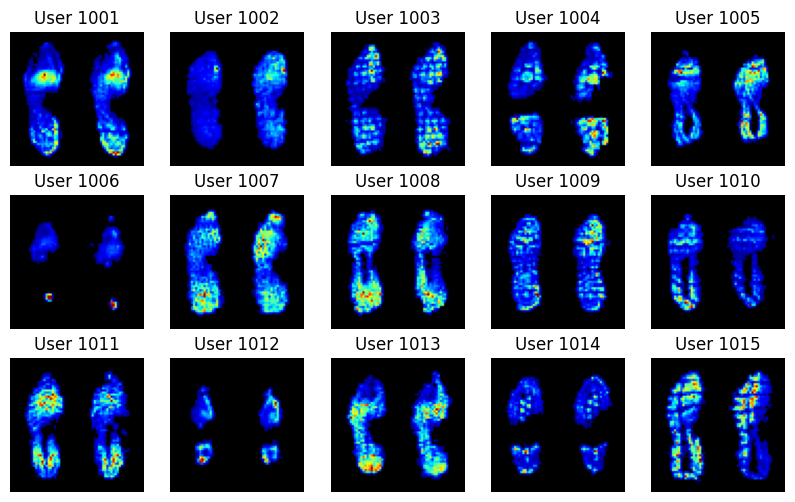

In [19]:
# plot first stride for each reference user
_,footstep_idx = np.unique(dataset_ref.labels,return_index = True)

fig, ax = plt.subplots(3, 5, figsize=(10, 6))
ax = ax.flatten()

# define colormap
jet = mpl.colormaps['jet'](np.linspace(0, 1, 256))
jet[0] = [0,0,0,1]
cmap = mpl.colors.ListedColormap(jet)

for i,idx in enumerate(footstep_idx):
    (footstep_l,footstep_r),y = dataset_ref.__getitem__(idx)

    footstep_l = footstep_l.squeeze()
    footstep_r = footstep_r.squeeze()
    img = np.concatenate((footstep_l.max(0)[0],footstep_r.max(0)[0]),axis = 1) # flatten into image for display
    ax[i].imshow(img,cmap = cmap)
    ax[i].set_axis_off()
    ax[i].set_title('User ' + str(y.item()))
plt.show()

### Get Reference Embeddings using Trained CNN

Pass the reference footsteps through the trained CNN to obtain 512 features for each footstep pair. 

In [20]:
clf.eval()

ref_embeds = []
with torch.no_grad():

    for id_batch, ((x_left_batch,x_right_batch), y_batch) in enumerate(dataloader_ref):

        x_left_batch, x_right_batch = x_left_batch.to(device), x_right_batch.to(device)

        y_batch_pred,embeds = clf(x_left_batch,x_right_batch)
        
        embeds = F.normalize(embeds, p=2, dim=1)

        embeds = embeds.cpu()
        ref_embeds.append(embeds)

ref_embeds = np.concatenate(ref_embeds, axis = 0)

print('Reference Feature Set:',ref_embeds.shape)


Reference Feature Set: (75, 512)


## Step 3: Perform Verification on the Probe Set

### Load Probe Samples

There are 10,000 probes with claimed identities that need to be verified. These are in the same format as the reference samples, with a single metadata file containing the claims and a single .npz file with the footsteps stored in a dictionary. 

In [21]:
metadata_probe = pd.read_csv(datapath_probe / 'probe_metadata.csv',index_col = 'Index') 
footsteps_probe = np.load(datapath_probe / 'probe_data.npz')

metadata_probe.head()

,ClaimID
Index,
0,1014
1,1012
2,1014
3,1007
4,1015


### Get Embeddings for Probe Set

Create a dataloader and pass the probe samples through the trained network for feature extraction.

In [22]:
clf.eval()

dataset_probe = Test_Dataset(footsteps_probe, metadata_probe,transform = transform_fn,ref = False)
dataloader_probe = DataLoader(dataset_probe, batch_size=batch_sz, shuffle=False)

probe_embeds = []
with torch.no_grad():

    for id_batch, ((x_left_batch,x_right_batch), y_batch) in enumerate(dataloader_probe):

        x_left_batch, x_right_batch = x_left_batch.to(device), x_right_batch.to(device)

        y_batch_pred,embeds = clf(x_left_batch,x_right_batch)
        
        embeds = F.normalize(embeds, p=2, dim=1)

        embeds = embeds.cpu()
        probe_embeds.append(embeds)

probe_embeds = np.concatenate(probe_embeds, axis = 0)

print('Probe Feature Set:',probe_embeds.shape)

Probe Feature Set: (10000, 512)


### Compute Similarity Scores for Each Sample in Probe Set

Compare each probe to the reference samples to obtain a similarity score. Here, we use cosine distance for comparison.

In [23]:
dist_metric = 'cosine'

all_score = []
for claim,probe_embed in zip(dataset_probe.labels,probe_embeds):
    user_idx = dataset_ref.labels == claim

    # get distance between probe and claimed user's nearest reference stride 
    dist = cdist(probe_embed[None,:],ref_embeds[user_idx],dist_metric).min() 

    # convert to similarity score between 0 and 1
    score = ((1 - dist) + 1)/2
   
    all_score.append(score)

all_score = np.array(all_score) 

Select a score threshold for making match/non-match decisions. Probes will be considered a 'match' if the similarity is greater than or equal to the threshold, and a 'non-match' otherwise. Based on a visualization of the score distributions, we select a threshold of 0.7.  

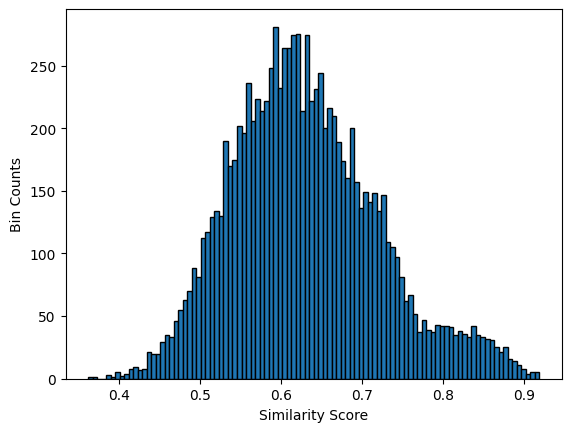

In [25]:
plt.hist(all_score,bins = 100,edgecolor = 'k')
plt.xlabel('Similarity Score')
plt.ylabel('Bin Counts')
plt.show()

In [26]:
threshold = np.array([0.7])

## Step 4. Export Results in CodaBench Submission Format

Finally, write the similarity scores and threshold to text files for submission. This function packages these into a zip file that can be uploaded to the CodaBench platform. 

In [27]:
#  - scores: (10000,) element numpy array in range [0.0,1.0] 
#  - threshold: (1,) element numpy array in range [0.0, 1.0]
#  - output: (optional) filename of created zipfile

def package_predictions_for_submission(scores, threshold, output=pathlib.Path('./submission.zip')):
  
  filename_variable_pairs = {
    'threshold.txt': threshold,
    'scores.txt': scores,
  }

  # The most straightforward way to populate a zip file is with actual files on disk
  # Therefore, temporarily create each file in the working directory  
  for f, d in filename_variable_pairs.items():
    np.savetxt(f, d)

  # Create the zip file
  with zipfile.ZipFile(output, mode='w') as z:
    for f, _ in filename_variable_pairs.items():
      z.write(f)
  
  # ...the cleanup after ourselves to avoid clutter
  for f, _ in filename_variable_pairs.items():
    os.remove(f)

  print(f'Successfully created CodaBench submission file: `{output}`. Upload this zip file to CodaBench to complete your submission.')

In [28]:
package_predictions_for_submission(all_score, threshold, output=pathlib.Path('./example_submission.zip'))

Successfully created CodaBench submission file: `example_submission.zip`. Upload this zip file to CodaBench to complete your submission.
